# `numpy` Neural Networks: Momentum & Weight Regularization

We've got a multi-layer neural network that can learn to classify the "hard" data. However, training is a bit unstable. Let's implement some tricks of the trade to help stabilize the training process. Thanks to Eric Postma for suggesting this direction!

These training improvements require adjusting some functions that we've already defined. In this notebook we will copy/paste a new version of each function that is being adjusted so that we can compare to the old version. We'll comment important changes in the code.

First, all the boilerplate from the previous notebooks. Maybe it's getting time to use a `common.py`...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

The toy dataset

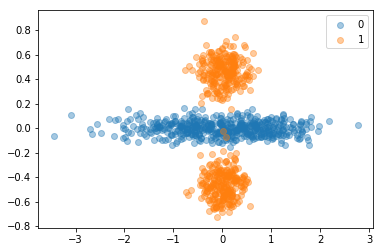

In [2]:
def rescale(X):
    return (X - X.mean(axis=0)) / (X.var(axis=0))

np.random.seed(1337)
n_samples = 1000
X0 = np.random.normal(loc=[0,0], scale=[2,0.5], size=(int(n_samples/2), 2))
X11 = np.random.normal(loc=[0,4], scale=[0.5,1], size=(int(n_samples/4), 2))
X12 = np.random.normal(loc=[0,-4], scale=[0.5,1], size=(int(n_samples/4), 2))
X1 = np.vstack([X11, X12])
X = np.vstack([X0, X1])

X = rescale(X)

y0 = np.zeros(shape=(int(n_samples/2), 1))
y1 = np.ones(shape=(int(n_samples/2), 1))
yhat = np.vstack([y0, y1])

# shuffle the data
inds = np.random.permutation(np.arange(n_samples))
X = X[inds]
yhat = yhat[inds]

X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

Activations & cost function

In [3]:
def relu(z):
    return np.where(z>0, z, 0)
    
def drelu_dz(z):
    return np.where(z>0, 1, 0)

def sig(z):
    return 1 / (1 + np.exp(-z))

def dsig_dz(z):
    return sig(z) * (1 - sig(z))

def J(y, yhat):
    eps = 1e-8
    return -(yhat*np.log(y+eps) + (1-yhat)*np.log(1-y+eps))

def dJ_dy(y, yhat):
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)


Model initialization, forward & backward passes. Set the random seed so that we always initialize to the same values, so that we can compare different training strategies fairly.

In [4]:
def init_model(shape):
    np.random.seed(1234)
    w = {}
    b = {}
    for layer in range(1, len(shape)):  # no weights for the input layer
        w[layer] = np.random.normal(0, 0.5, size=(shape[layer-1], shape[layer]))  # dim: from_units, to_units
        b[layer] = np.random.normal(0, 0.5, size=(shape[layer], 1))  # dim: to_units, 1
    return w,b

def forwardn(x0, w, b):
    n_layers = len(w)
    x_prev = x0
    for l in range(1, n_layers):
        x_l = relu(np.dot(x_prev, w[l]) + b[l].T)  # output of a hidden layer
        x_prev = x_l
    return sig(np.dot(x_prev, w[n_layers]) + b[n_layers].T)  # output of output layer

def backwardn(x0, w, b, y, yhat, alpha):
    n_layers = len(w)
    z = {}
    x = {0:x0}
    
    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.dot(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
        
    delta = {}
    
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = dJ_dy(y, yhat)*dsig_dz(z[n_layers])
        else:  # recursive case
            delta[l] = np.dot(w[l+1], delta[l+1]) * drelu_dz(z[l]).T

        # update weights and biases
        w[l] -= alpha * np.multiply(delta[l], x[l-1]).T
        b[l] -= alpha * delta[l]
    
    return w, b

Training function

In [5]:
def trainn(X, yhat, shape, alpha, n_epoch):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(n_samples):
            x0 = X[i,:]; yh = yhat[i]
            y = forwardn(x0, w, b)  # prediction for one sample
            w, b = backwardn(x0, w, b, y, yh, alpha)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Train the MLP from the previous notebook

Training accuracy after epoch 149: 99.8000%
CPU times: user 13.6 s, sys: 658 ms, total: 14.3 s
Wall time: 13.8 s


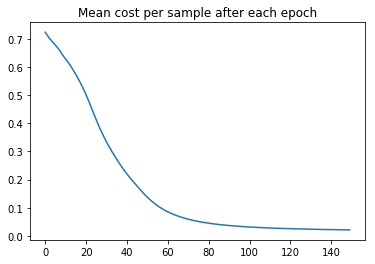

In [6]:
shape = (2,3,4,1)
alpha = 0.001
n_epoch = 150
%time w, b, costs = trainn(X, yhat, shape, alpha, n_epoch)
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

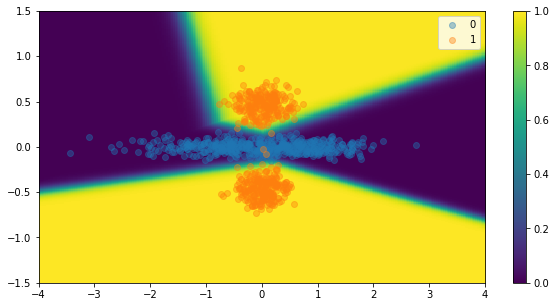

In [7]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forwardn([i,j], w, b)

X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

# Mini-Batches

So far we have been doing stochastic gradient descent (SGD), which takes one step per sample. However, this can be a bit chaotic: we make a lot of updates using not a lot of data. We can start to smooth our process out by using so-called mini-batches (small groups of data points), and taking a step in the average direction dictated by doing backprop on each of those points.

We first adjust our backward pass to accept multiple samples, and update `w` and `b` with the mean steps.

Our new backprop functions, `backward_mini` will now accept a matrix `X0` as input, calculate the updates for each row, and average over those before making one update to `w` and `b`.

Let's update our notation and call the update rule

$$ w^\ell\ \rightarrow\ w^\ell - \alpha\,dw^\ell $$

(and similar for $b$). This will allow us to talk more generally about changes to the update rule. 

Consider mini-batches of $m_{batch}$ samples, and let's consider weights between layers with $n^{\ell-1}$ and $n^\ell$ units. In the SQG case, $\delta^\ell$ had a shape of $(n^\ell,\, 1)$ (the same shape as $b^\ell$). Now we stack our calculated $\delta$s so that we get a matrix of shape $(n^\ell,\, $m_{batch}$)$, one column per sample. The block of samples itself has shape $($m_{batch}$,\, n^{\ell-1})$. Recalling that $dw^\ell = \delta^\ell x^{\ell-1}$, we see the the dimension of size $m_{batch}$ is summed over (effectively summing over all the samples). For that reason we adjust the update rule to

$$ dw^\ell = \delta^\ell x^{\ell-1} / m_{batch}  $$

so that we get an average instead of a sum. The approach for $db$ is simpler: we simply take a mean over the axis corresponding to the features. It's important here to take the mean using `delta[l].mean(axis=1, keepdims=True)`, where `keepdims=True` prevents numpy from making annoying 0-dimensional vectors after the mean.

In [8]:
def backward_mini(X0, w, b, y, yhat, alpha):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T  # matmul instead of dot
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            # delta is a column, so make the deltas from the samples go along axis 1 by transposing
            delta[l] = (dJ_dy(y, yhat) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
        
        dw = np.matmul(delta[l], x[l-1]).T / batch_size  # mean over samples
        db = delta[l].mean(axis=1, keepdims=True)  # mean over samples
        
        # update weights and biases
        w[l] -= alpha * dw
        b[l] -= alpha * db
    
    return w, b

The training script requires minimal adjustment. We add an extra parameter `batch_size` and use it to loop through the training set taking steps of that size, passing these blocks to the backward function.

In [9]:
def train_mini(X, yhat, shape, alpha, n_epoch, batch_size):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b = backward_mini(X_batch, w, b, y, yh, alpha)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Training accuracy after epoch 1999: 99.7000%
CPU times: user 11.8 s, sys: 1.95 s, total: 13.8 s
Wall time: 12.2 s


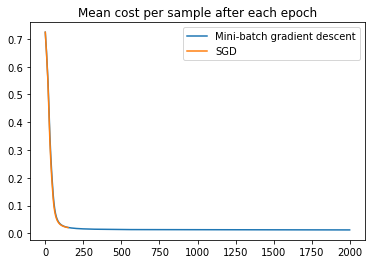

In [10]:
batch_size = 32
shape = (2,3,4,1)
alpha = 0.03
n_epoch = 2000
%time w_mini, b_mini, costs_mini = train_mini(X, yhat, shape, alpha, n_epoch, batch_size)
plt.plot(costs_mini, label='Mini-batch gradient descent')
plt.plot(costs, label='SGD')
plt.legend()
plt.title('Mean cost per sample after each epoch');

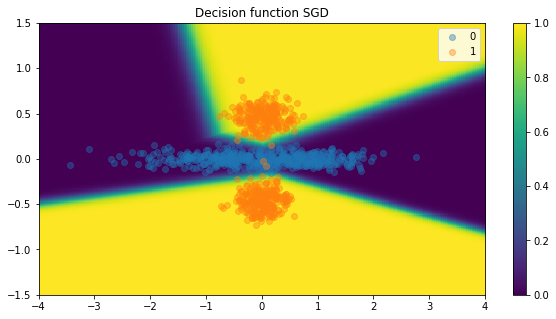

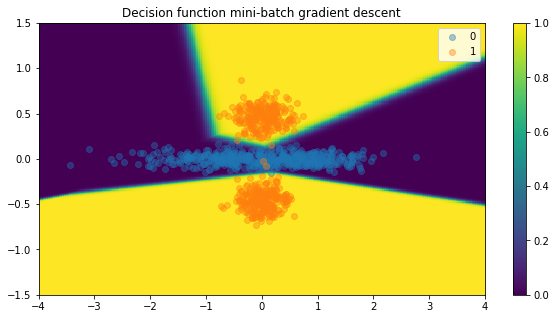

In [11]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map_mini = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_mini[m,n] = forwardn([i,j], w_mini, b_mini)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend()
plt.title('Decision function SGD')
plt.show;

plt.figure(figsize=(10,5))
plt.imshow(fun_map_mini, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.title('Decision function mini-batch gradient descent')
plt.legend();

We see that we can go through *many* more epochs in the same amount of wall-clock time, as we take far fewer update steps per epoch. However, the convergence happens in around the same number of epochs, so in the same amount of time we can make much more progress. Comparing the plots, we see that the gradients are much sharper, i.e. the model is much more sure of itself.

# Momentum

The idea behind momentum is to take update steps that are an average over the current step calculated from backprop, and the previous step. The motivation is that small oscillations should cancel out, while actual progress should not be affected by the averaging.

In practice this is done by taking an exponentially weighted moving average of the $dw$ and $db$ obtained by backprop, and updating using the average step. The weighting is parameterized by the momentum parameter $\beta$. At step $t$, the updates are:

$$\begin{align*}
dw_{mom}[t] = \beta\, dw_{mom}[t-1] + (1-\beta)\, dw_{backprop}[t]
\end{align*}$$

So the $dw$ calculated from backprop $\tau$ steps ago appears as a term in the weighted sum with a weight $\beta^\tau$. A typical value for $\beta$ is around 0.9, which corresponds to having the last approximately 10 steps significantly contributing to $dw$.

In our implementation we now need to keep track of what the previous $dw$ and $db$ were for each layer, and update these values using the newly calculated ones from backprop. We do this by keeping them in a dictionary.

In [12]:
def backward_mom(X0, w, b, y, yhat, alpha, beta):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}
    
    # initialize dw and db to zero
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = (dJ_dy(y, yhat) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
            
        # Updates from backprop
        dw_new = np.matmul(delta[l], x[l-1]).T / batch_size
        db_new = delta[l].mean(axis=1, keepdims=True)
        
        # Exp. weighted average
        dw[l] = beta*dw[l] + (1-beta)*dw_new
        db[l] = beta*db[l] + (1-beta)*db_new
        
        # update weights and biases
        w[l] -= alpha * dw[l]
        b[l] -= alpha * db[l]
    
    return w, b

def train_mom(X, yhat, shape, alpha, n_epoch, batch_size, beta):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b = backward_mom(X_batch, w, b, y, yh, alpha, beta)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Training accuracy after epoch 149: 99.7000%
CPU times: user 27 s, sys: 1.27 s, total: 28.3 s
Wall time: 27.6 s


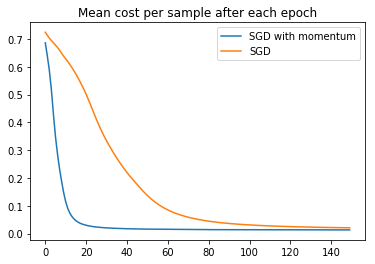

In [13]:
batch_size = 1
shape = (2,3,4,1)
alpha = 0.01
beta = 0.5
n_epoch = 150
%time w_mom, b_mom, costs_mom = train_mom(X, yhat, shape, alpha, n_epoch, batch_size, beta)
plt.plot(costs_mom, label='SGD with momentum')
plt.plot(costs, label='SGD')
plt.legend()
plt.title('Mean cost per sample after each epoch');

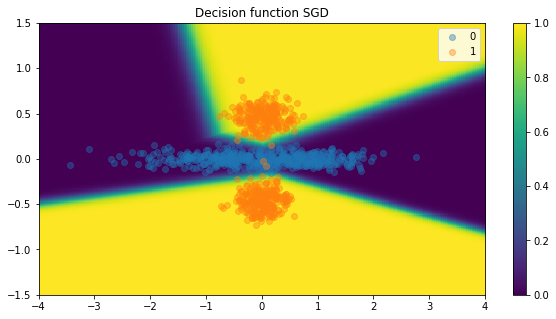

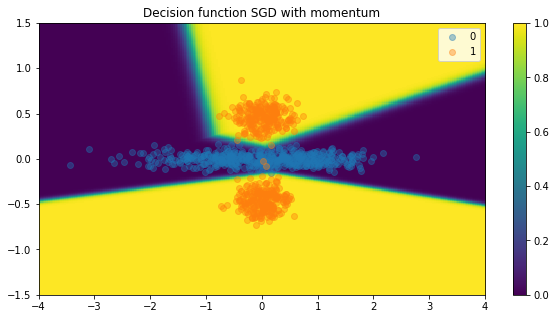

In [14]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map_mom = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_mom[m,n] = forwardn([i,j], w_mom, b_mom)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend()
plt.title('Decision function SGD')
plt.show();

plt.figure(figsize=(10,5))
plt.imshow(fun_map_mom, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.title('Decision function SGD with momentum')
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

Here we see that in the same number of epochs, we achieve much sharper gradients due to faster convergence and therefore more time spent around the minimum.

# Weight Regularization

The goal of weight regularization is actually the opposite of the previous two techniques. Faster convergence is good to a point, but can lead to overtraining. To help reduce this, we can penalize the size of the model's weights in the cost function. Large weights can lead to very sharp derivatives, or to over-reliance on one feature. To do this, we define a new cost function, which contains an extra term. We will do $L_2$ regularization, which penalizes the sum-of-squares of all the weights. The amount of regularization is controlled by the new parameter $\lambda$:

$$ J_{reg}(y,\hat y, w, \lambda) = J(y,\hat y) + \frac{\lambda}{2} \sum_{\ell,i,j} (w^\ell_{ij})^2 $$

Note that the partial derivative with respect to $y$ remains unchanged, but since there is now an explicit $w$ dependence, we will need to incorporate this into $dw$. In matrix notation,

$$ \frac{\partial J_{reg}}{\partial y} = \frac{\partial J}{\partial y} $$

$$ \frac{\partial J_{reg}}{\partial w^\ell} = \lambda w^\ell $$


In [15]:
def Jreg(y, yhat, w, lam):
    eps = 1e-8
    cost_term = -(yhat*np.log(y+eps) + (1-yhat)*np.log(1-y+eps)) # Same as J
    reg_term = 0.5*lam*sum([(w[l]**2).sum() for l in w])  # Weight regularization
    return cost_term + reg_term

def dJreg_dy(y, yhat, w, lam):  # Same as dJ_dy, just redefine to match parameters of Jreg
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)

In [43]:
y = np.linspace(0,1, num=5)
yh = np.ones(5)
print('y     :', *[f'{i:>8.3f}' for i in y])
print('y_hat :', *[f'{i:>8.3f}' for i in yh])
print()
print('J     :', *[f'{i:>8.3f}' for i in J(y,yh).T])
print('J_reg :', *[f'{i:>8.3f}' for i in Jreg(y,yh,w,1).T])

y     :    0.000    0.250    0.500    0.750    1.000
y_hat :    1.000    1.000    1.000    1.000    1.000

J     :   18.421    1.386    0.693    0.288   -0.000
J_reg :   52.032   34.997   34.304   33.899   33.611


$J_{reg}$ will always have a higher value than $J$ since we have added an extra non-negative term.

In [17]:
def backward_reg(X0, w, b, y, yhat, alpha, beta, lam):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}
    
    # initialize dw and db
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = (dJreg_dy(y, yhat, w, lam) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
            
        # dw_new now with extra term from explicit w dependence!
        dw_new = (np.matmul(delta[l], x[l-1]).T / batch_size) + lam*w[l]  
        db_new = delta[l].mean(axis=1, keepdims=True)
        
        dw[l] = beta*dw[l] + (1-beta)*dw_new
        db[l] = beta*db[l] + (1-beta)*db_new
        
        # update weights and biases
        w[l] -= alpha * dw[l]
        b[l] -= alpha * db[l]
    
    return w, b

def train_reg(X, yhat, shape, alpha, n_epoch, batch_size, beta, lam):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b = backward_reg(X_batch, w, b, y, yh, alpha, beta, lam)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Training accuracy after epoch 149: 99.4000%
CPU times: user 27.6 s, sys: 1.63 s, total: 29.2 s
Wall time: 27.9 s


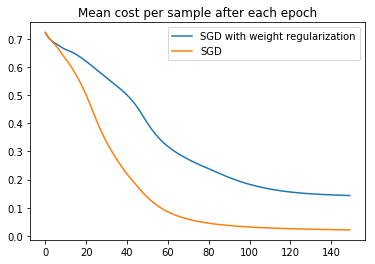

In [18]:
batch_size = 1
shape = (2,3,4,1)
alpha = 0.001
beta = 0
lam = 0.02
n_epoch = 150
%time w_reg, b_reg, costs_reg = train_reg(X, yhat, shape, alpha, n_epoch, batch_size, beta, lam)
plt.plot(costs_reg, label='SGD with weight regularization')
plt.plot(costs, label='SGD')
plt.legend()
plt.title('Mean cost per sample after each epoch');

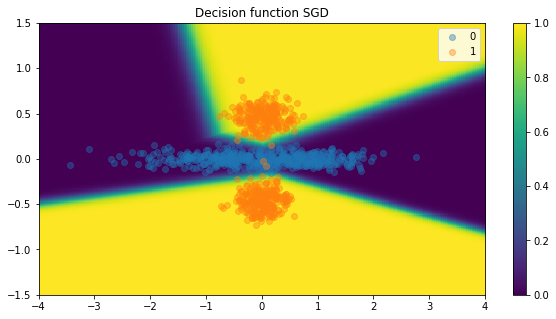

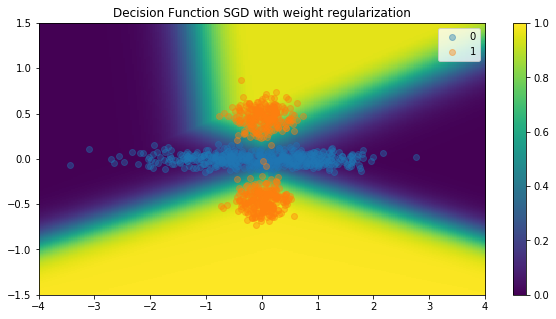

In [19]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map_reg = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_reg[m,n] = forwardn([i,j], w_reg, b_reg)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend()
plt.title('Decision function SGD')
plt.show();

plt.figure(figsize=(10,5))
plt.imshow(fun_map_reg, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.title('Decision Function SGD with weight regularization')
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

We see that regularizing the weights has had all the expected effects:

* The cost function remains higher in value than its unregularized counterpart.
* The gradients are much less steep than in the unregularized model.

For this toy dataset these effects aren't really desireable, but this kind of regularization can prevent the decision boundary from becoming too contorted by smoothing out small variations and curves.

It remains to be seen if the weights are also indeed lower than the unregularized weights. We plot them all on a scatter plot to investigate:

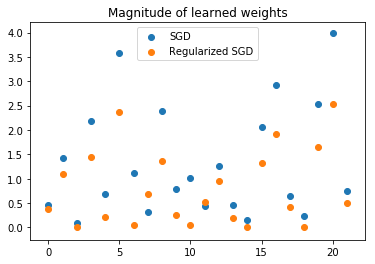

In [21]:
all_w = np.abs(np.hstack([w[l].reshape(-1) for l in w]))
all_w_reg = np.abs(np.hstack([w_reg[l].reshape(-1) for l in w_reg]))
plt.scatter(np.arange(len(all_w)), all_w, label='SGD')
plt.scatter(np.arange(len(all_w_reg)), all_w_reg, label='Regularized SGD')
plt.title('Magnitude of learned weights')
plt.legend();

All but one of the learned weights are lower in magnitude than the unregularized ones! They also follow the same basic pattern, so this is indeed the same model, just a more smoothed out version. 